In [3]:
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
from catalyst import dl
from catalyst import utils
from torch.utils.data import DataLoader

import dataset as ds
import transformations

In [4]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
checkpoint = utils.torch.load_checkpoint(
    r"C:\Users\Emily\Documents\GitHub\ML-BLIF\Code\pytorch\Segmentation_2\FPN\checkpoints\best_full.pth")

In [8]:
#model = smp.Unet(classes=4, activation="softmax2d", encoder_name="resnet152", encoder_weights="imagenet")
model = smp.FPN(classes=4, activation="softmax2d", encoder_name="timm-resnest50d_1s4x24d", encoder_weights="imagenet")

In [9]:
loss_fn = smp.utils.losses.DiceLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4},

    # decrease lr for encoder in order not to permute
    # pre-trained weights with large gradients on training start
    {'params': model.encoder.parameters(), 'lr': 1e-6},
])
utils.torch.unpack_checkpoint(checkpoint=checkpoint, model=model, criterion=loss_fn, optimizer=optimizer)
model.eval()

FPN(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_runni

In [13]:
ENCODER = "timm-resnest50d_1s4x24d"
ENCODER_WEIGHTS = "imagenet"
test_ds = ds.Dataset(r"C:\Users\Emily\Documents\Bachelor_Drohnen_Bilder\splitted\train\img",
                     r"C:\Users\Emily\Documents\Bachelor_Drohnen_Bilder\splitted\train\mask", size=128 * 8,
                     preprocessing=transformations.get_preprocessing(
                         preprocessing_fn=smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS))
                     )
predict_loader = DataLoader(test_ds, batch_size=1)
vis_loader = DataLoader(test_ds, batch_size=1)


In [14]:
runner = dl.SupervisedRunner(model=model,
                             input_key="features", output_key="logits", target_key="targets", loss_key="loss"
                             )

In [15]:
x = runner.predict_loader(
    model=model,
    loader=predict_loader
)
preds = iter(x)
truths = iter(vis_loader)

Einfacher Weg

In [256]:
prediction = next(preds)["logits"]
image, mask = next(truths)

In [257]:
prediction = prediction[0]
image = image[0].permute(2, 1, 0)
mask = mask[0].permute(2, 1, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


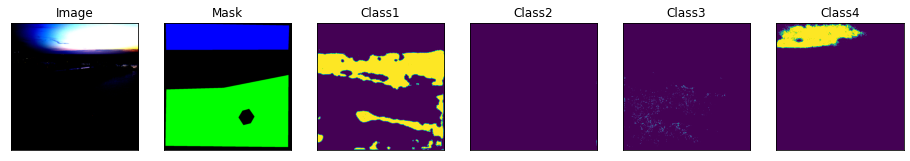

In [260]:
perc = 0.8
#wasser = cv2.rotate(,cv2.ROTATE_90_COUNTERCLOCKWISE)
#strand = cv2.rotate(),cv2.ROTATE_90_COUNTERCLOCKWISE)
#himmel = cv2.rotate(cv2.flip((prediction[2] > perc).int().numpy(), 1),cv2.ROTATE_90_COUNTERCLOCKWISE)
class1 = cv2.rotate((prediction[0] > perc).int().numpy(), cv2.ROTATE_90_CLOCKWISE)  #Background
class2 = cv2.rotate((prediction[1] > perc).int().numpy(), cv2.ROTATE_90_CLOCKWISE)  #Strand
class3 = cv2.rotate((prediction[2] > perc).int().numpy(), cv2.ROTATE_90_CLOCKWISE)  #Wasser
class4 = cv2.rotate((prediction[3] > perc).int().numpy(), cv2.ROTATE_90_CLOCKWISE)  #Himmel
visualize(image=image, mask=mask, class1=class1, class2=class2, class3=class3, class4=class4)

Display All

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


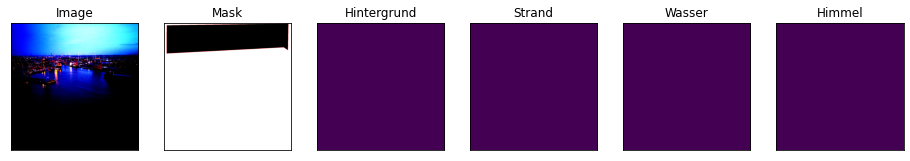

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


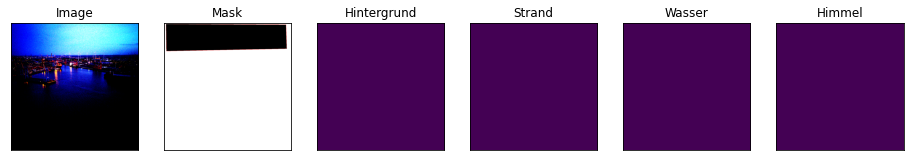

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


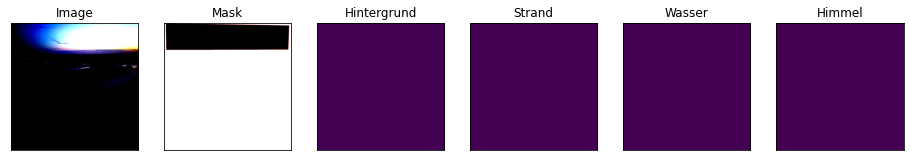

KeyboardInterrupt: 

In [16]:
perc = 0.5
b = 5
for idx, (pred, (image, mask)) in enumerate(zip(x, predict_loader)):
    pred = pred["logits"][0]
    image = image[0].permute(1, 2, 0)
    mask = mask[0].permute(1, 2, 0)
    #class1 = cv2.rotate((pred[0] > perc).int().numpy(), cv2.ROTATE_90_CLOCKWISE)  #Background
    #class2 = cv2.rotate((pred[1] > perc).int().numpy(), cv2.ROTATE_90_CLOCKWISE)  #Strand
    #class3 = cv2.rotate((pred[2] > perc).int().numpy(), cv2.ROTATE_90_CLOCKWISE)  #Wasser
    #class4 = cv2.rotate((pred[3] > perc).int().numpy(), cv2.ROTATE_90_CLOCKWISE)  #Himmel
    class1 = (pred[0] > perc).int()  #Background
    class2 = (pred[1] > perc).int()  #Strand
    class3 = (pred[2] > perc).int()  #Wasser
    class4 = (pred[3] > perc).int()  #Himmel
    visualize(image=image, mask=mask, Hintergrund=class1, Strand=class2, Wasser=class3, Himmel=class4)
    if idx == b:
        break

In [9]:
eval_ds = ds.Dataset(r"C:\Users\Emily\Documents\Bachelor_Drohnen_Bilder\splitted\test\img",
                     r"C:\Users\Emily\Documents\Bachelor_Drohnen_Bilder\splitted\test\mask", size=128 * 8,
                     preprocessing=transformations.get_preprocessing(
                         preprocessing_fn=smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS))
                     )
eval_loader = DataLoader(eval_ds, batch_size=4)
#eval = runner.evaluate_loader(loader=eval_loader, model=model, verbose=True)

In [10]:
test_epoch = smp.utils.train.ValidEpoch(model=model, loss=loss_fn, metrics=[
    smp.utils.metrics.IoU(threshold=0.5), smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5), smp.utils.metrics.Recall(threshold=0.5)
], device="cpu")

In [11]:
logs = test_epoch.run(eval_loader)

valid: 100%|██████████| 6/6 [04:09<00:00, 41.60s/it, dice_loss - 0.4558, iou_score - 0.4777, accuracy - 0.8587, precision - 0.8595, recall - 0.5186]


In [12]:
logs

{'dice_loss': 0.45578597982724506,
 'iou_score': 0.47766891618569696,
 'accuracy': 0.8587310810883839,
 'precision': 0.8595237731933594,
 'recall': 0.518554762005806}

In [18]:
logs

{'dice_loss': 0.5384380221366882,
 'iou_score': 0.42931123077869415,
 'accuracy': 0.8494610289732615,
 'precision': 0.8849101662635803,
 'recall': 0.45355942845344543}